# Parking Space Detection using YOLOv8

## 0. Environment Setup

In [2]:
!pip install -q roboflow
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.

In [39]:
import os
from dotenv import load_dotenv
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from roboflow import Roboflow
from ultralytics import YOLO
from IPython.display import Image, display
from pathlib import Path
import random

## 1. Dataset Download and Directory Structure

### 1.1 Roboflow Integration

In [4]:
load_dotenv()

True

In [5]:
api_key = os.getenv("ROBOFLOW_API_KEY")

In [6]:
rf = Roboflow(api_key=api_key)
project = rf.workspace("brad-dwyer").project("pklot-1tros")
dataset = project.version(2).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to PKLot-2 in yolov8:: 100%|██████████| 24844/24844 [00:03<00:00, 6822.73it/s]


### 1.2 Dataset Paths

In [7]:
dataset_dir = "PKLot-2/train"
image_dir = os.path.join(dataset_dir, "images")
label_dir = os.path.join(dataset_dir, "labels")

In [8]:
class_names = ['space-empty', 'space-occupied']

## 2. Visualizing Sample Images

In [9]:
N = 5
image_files = os.listdir(image_dir)[:N]

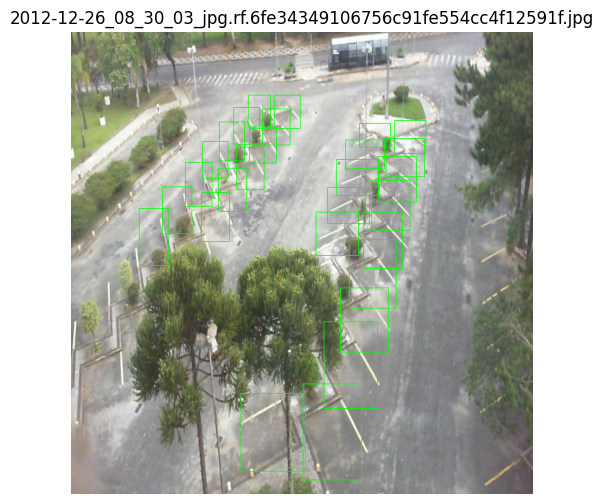

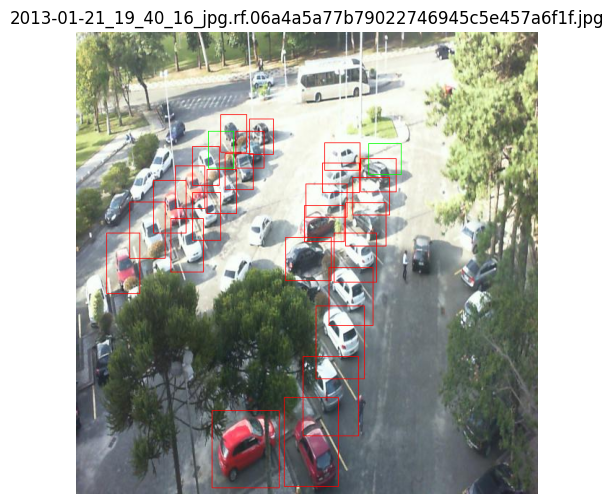

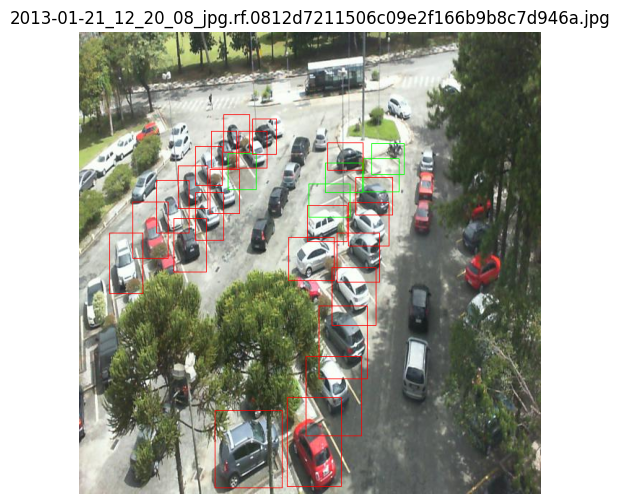

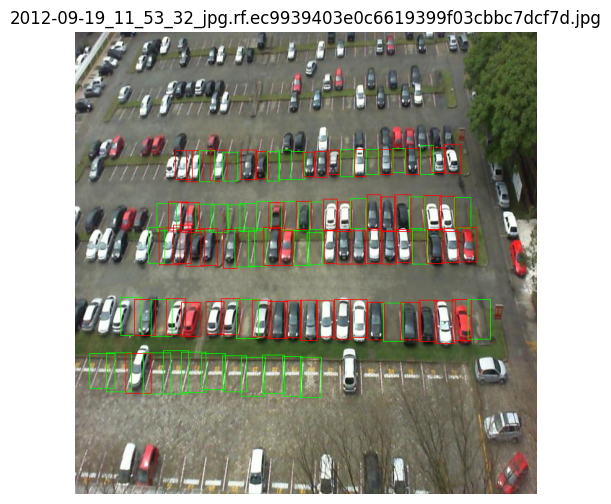

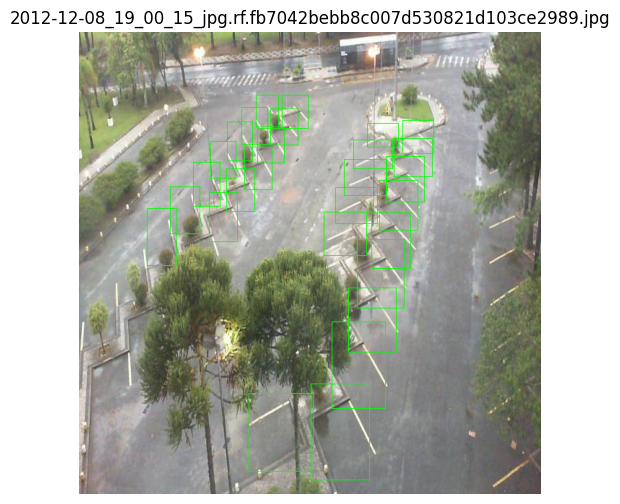

In [10]:
for image_file in image_files:
  img_path = os.path.join(image_dir, image_file)
  label_path = os.path.join(label_dir, image_file.replace(".jpg", ".txt"))

  # Load image
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image_height, image_width, _ = image.shape

  # Read label file
  if os.path.exists(label_path):
    with open(label_path, "r") as f:
      labels = f.readlines()

    for label in labels:
      class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.strip().split())
      x1 = int((x_center - bbox_width / 2) * image_width)
      y1 = int((y_center - bbox_height / 2) * image_height)
      x2 = int((x_center + bbox_width / 2) * image_width)
      y2 = int((y_center + bbox_height / 2) * image_height)

      # Draw box and label
      color = (0, 255, 0) if class_id == 0 else (255, 0 ,0)
      cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)

  plt.figure(figsize=(8,6))
  plt.imshow(image)
  plt.axis("off")
  plt.title(image_file)
  plt.show()

## 3. Class Distribution Analysis

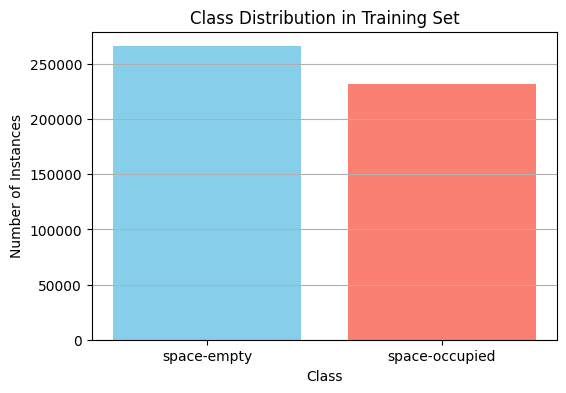

In [11]:
class_counts = Counter()

for label_file in os.listdir(label_dir):
  with open(os.path.join(label_dir, label_file), "r") as f:
    lines = f.readlines()
    for line in lines:
      class_id = int(line.strip().split()[0])
      class_counts[class_id] += 1

counts = [class_counts[i] for i in range(len(class_names))]

plt.figure(figsize=(6, 4))
plt.bar(class_names, counts, color=['skyblue', 'salmon'])
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.grid(axis='y')
plt.show()

## 4. Training YOLOv8 Model

In [13]:
model = YOLO("yolov8x.pt")

model.train(
    data = "PKLot-2/data.yaml",
    epochs=50,
    imgsz=640,
    batch=16,
    fliplr=0.5,
    flipud=0.0,
    degrees=20,
    scale=0.9,
    translate=0.1,
    shear=0.1,
    hsv_h=0.02,
    hsv_s=0.7,
    hsv_v=0.4
)

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=PKLot-2/data.yaml, degrees=20, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.02, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretraine

train: Scanning /content/PKLot-2/train/labels.cache... 8691 images, 189 backgrounds, 0 corrupt: 100%|██████████| 8691/8691 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 866.5±727.0 MB/s, size: 66.2 KB)


val: Scanning /content/PKLot-2/valid/labels.cache... 2483 images, 59 backgrounds, 0 corrupt: 100%|██████████| 2483/2483 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      16.4G       1.35     0.7907      1.171        264        640: 100%|██████████| 544/544 [02:10<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:20<00:00,  3.83it/s]


                   all       2483     143316      0.944      0.945      0.971      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      16.4G     0.9827      0.523     0.9932        386        640: 100%|██████████| 544/544 [02:03<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:20<00:00,  3.85it/s]


                   all       2483     143316      0.959      0.968      0.975      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      16.4G     0.8506     0.4684     0.9424        402        640: 100%|██████████| 544/544 [02:01<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:19<00:00,  3.91it/s]


                   all       2483     143316      0.963      0.975      0.977      0.834

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      16.5G     0.7442     0.4262     0.9015        494        640: 100%|██████████| 544/544 [02:00<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


                   all       2483     143316       0.96      0.976      0.983      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      16.5G     0.6575     0.3953     0.8729        205        640: 100%|██████████| 544/544 [02:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


                   all       2483     143316      0.964      0.972      0.988      0.896

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      16.5G     0.5968     0.3671     0.8558        598        640: 100%|██████████| 544/544 [02:00<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:19<00:00,  4.10it/s]


                   all       2483     143316      0.963      0.969      0.988      0.902

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      16.5G      0.566     0.3519     0.8474        193        640: 100%|██████████| 544/544 [02:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.12it/s]


                   all       2483     143316      0.961      0.969      0.987      0.921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      16.5G     0.5396      0.339      0.841        119        640: 100%|██████████| 544/544 [02:00<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


                   all       2483     143316      0.969      0.967      0.989      0.937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      16.5G     0.4978     0.3236     0.8313        362        640: 100%|██████████| 544/544 [02:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.16it/s]


                   all       2483     143316      0.975      0.974      0.989      0.926

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      16.5G     0.4848     0.3136     0.8276        501        640: 100%|██████████| 544/544 [02:00<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.11it/s]


                   all       2483     143316      0.978      0.966      0.992      0.938

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      16.5G     0.4643     0.3041      0.822        287        640: 100%|██████████| 544/544 [02:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:19<00:00,  4.07it/s]


                   all       2483     143316       0.98      0.972      0.992      0.941

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      16.5G     0.4381     0.2863     0.8163        219        640: 100%|██████████| 544/544 [02:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


                   all       2483     143316      0.981      0.972      0.991       0.95

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      16.5G     0.4391     0.2926     0.8175        380        640: 100%|██████████| 544/544 [02:00<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.15it/s]


                   all       2483     143316      0.977      0.979      0.993      0.956

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      16.5G     0.4229     0.2822     0.8145        304        640: 100%|██████████| 544/544 [02:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


                   all       2483     143316      0.988      0.975      0.993      0.959

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      16.5G     0.4114     0.2709     0.8113        280        640: 100%|██████████| 544/544 [02:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.17it/s]


                   all       2483     143316      0.986      0.985      0.993      0.964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      16.5G     0.4089     0.2705     0.8111         58        640: 100%|██████████| 544/544 [02:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


                   all       2483     143316      0.987      0.978      0.994      0.937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      16.5G     0.3957     0.2638     0.8092        231        640: 100%|██████████| 544/544 [02:00<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


                   all       2483     143316      0.989       0.99      0.994      0.951

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      16.5G     0.3915     0.2611     0.8091        636        640: 100%|██████████| 544/544 [02:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


                   all       2483     143316      0.991      0.991      0.994      0.976

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      16.5G     0.3783     0.2502     0.8043        229        640: 100%|██████████| 544/544 [01:59<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


                   all       2483     143316      0.988      0.987      0.994      0.966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      16.5G     0.3733     0.2497     0.8033        100        640: 100%|██████████| 544/544 [02:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.19it/s]


                   all       2483     143316      0.991      0.993      0.994      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      16.5G     0.3662     0.2377     0.8034        186        640: 100%|██████████| 544/544 [01:59<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


                   all       2483     143316      0.991      0.991      0.993      0.977

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      16.5G     0.3646     0.2396     0.8023        236        640: 100%|██████████| 544/544 [01:59<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.13it/s]


                   all       2483     143316      0.994      0.993      0.994      0.967

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      16.5G     0.3532     0.2282     0.8009        260        640: 100%|██████████| 544/544 [01:59<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


                   all       2483     143316      0.998      0.998      0.995      0.978

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      16.5G     0.3498     0.2295     0.7994        375        640: 100%|██████████| 544/544 [02:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.20it/s]


                   all       2483     143316      0.997      0.997      0.995      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      16.5G     0.3351     0.2181     0.7981        302        640: 100%|██████████| 544/544 [01:59<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


                   all       2483     143316      0.997      0.996      0.994      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      16.5G     0.3303     0.2145     0.7964        273        640: 100%|██████████| 544/544 [02:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


                   all       2483     143316      0.997      0.997      0.994      0.983

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      16.5G     0.3247     0.2086     0.7953        474        640: 100%|██████████| 544/544 [01:59<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


                   all       2483     143316      0.998      0.998      0.995      0.978

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      16.5G     0.3243     0.2123     0.7962        797        640: 100%|██████████| 544/544 [02:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


                   all       2483     143316      0.998      0.998      0.995      0.983

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      16.5G     0.3225     0.2107     0.7957        658        640: 100%|██████████| 544/544 [01:59<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


                   all       2483     143316      0.998      0.997      0.995      0.987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      16.5G     0.3142     0.2022     0.7941        419        640: 100%|██████████| 544/544 [02:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


                   all       2483     143316      0.998      0.999      0.995      0.987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      16.5G     0.3076     0.1991     0.7935        312        640: 100%|██████████| 544/544 [01:59<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


                   all       2483     143316      0.998      0.998      0.995      0.988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      16.5G     0.3002     0.1938     0.7918        372        640: 100%|██████████| 544/544 [01:59<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.22it/s]


                   all       2483     143316      0.996      0.997      0.994      0.988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      16.5G      0.294     0.1906     0.7911        333        640: 100%|██████████| 544/544 [02:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.21it/s]


                   all       2483     143316      0.998      0.998      0.995      0.987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      16.5G     0.2916     0.1877     0.7909        290        640: 100%|██████████| 544/544 [01:59<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


                   all       2483     143316      0.998      0.998      0.994       0.99

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      16.5G     0.2879     0.1868     0.7902        117        640: 100%|██████████| 544/544 [02:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.23it/s]


                   all       2483     143316      0.999      0.998      0.995      0.988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      16.5G     0.2854     0.1839     0.7902        457        640: 100%|██████████| 544/544 [01:59<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


                   all       2483     143316      0.999      0.999      0.995      0.989

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      16.5G     0.2795      0.182     0.7892         91        640: 100%|██████████| 544/544 [02:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


                   all       2483     143316      0.999      0.999      0.995       0.99

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      16.5G     0.2689     0.1732     0.7878        349        640: 100%|██████████| 544/544 [01:59<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


                   all       2483     143316      0.998      0.998      0.995      0.991

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      16.5G     0.2666     0.1748     0.7869        197        640: 100%|██████████| 544/544 [02:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


                   all       2483     143316      0.999      0.999      0.995      0.991

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      16.5G     0.2627     0.1706     0.7869        556        640: 100%|██████████| 544/544 [02:00<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


                   all       2483     143316      0.999      0.999      0.995      0.991
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      16.5G     0.2138     0.1443     0.7829        107        640: 100%|██████████| 544/544 [01:57<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.26it/s]


                   all       2483     143316      0.998      0.998      0.995      0.991

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      16.5G      0.205     0.1398      0.781        285        640: 100%|██████████| 544/544 [01:55<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


                   all       2483     143316      0.999      0.999      0.995      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      16.5G     0.1939     0.1341     0.7783        152        640: 100%|██████████| 544/544 [01:56<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


                   all       2483     143316      0.999      0.999      0.995      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      16.5G     0.1885      0.131     0.7769        225        640: 100%|██████████| 544/544 [01:55<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


                   all       2483     143316      0.999      0.999      0.995      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      16.5G     0.1824     0.1256     0.7755        211        640: 100%|██████████| 544/544 [01:56<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


                   all       2483     143316      0.999      0.999      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      16.5G     0.1766     0.1228     0.7754        152        640: 100%|██████████| 544/544 [01:55<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


                   all       2483     143316      0.999      0.999      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      16.5G      0.172     0.1194     0.7741        167        640: 100%|██████████| 544/544 [01:55<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.27it/s]


                   all       2483     143316      0.999      0.999      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      16.5G     0.1657     0.1161     0.7729        219        640: 100%|██████████| 544/544 [01:55<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.24it/s]


                   all       2483     143316      0.999      0.999      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      16.5G     0.1611      0.114     0.7729        218        640: 100%|██████████| 544/544 [01:56<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.28it/s]


                   all       2483     143316      0.999      0.999      0.995      0.993

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      16.5G     0.1572     0.1112     0.7718        292        640: 100%|██████████| 544/544 [01:55<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:18<00:00,  4.25it/s]


                   all       2483     143316      0.999      0.999      0.995      0.994

50 epochs completed in 1.946 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 136.7MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 4/78 [00:08<03:01,  2.46s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 78/78 [00:33<00:00,  2.30it/s]


                   all       2483     143316      0.999      0.982      0.988      0.987
           space-empty       2062      73629      0.999      0.967      0.981       0.98
        space-occupied       1967      69687      0.999      0.998      0.995      0.993
Speed: 0.1ms preprocess, 6.2ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ad9d0686bd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

## 5. Model Evaluation and Metrics

In [14]:
results = model.val()

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 112 layers, 68,125,494 parameters, 0 gradients, 257.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1576.2±518.0 MB/s, size: 69.7 KB)


val: Scanning /content/PKLot-2/valid/labels.cache... 2483 images, 59 backgrounds, 0 corrupt: 100%|██████████| 2483/2483 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   2%|▏         | 3/156 [00:05<05:13,  2.05s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 156/156 [00:35<00:00,  4.34it/s]


                   all       2483     143316      0.999      0.992      0.994      0.993
           space-empty       2062      73629      0.999      0.995      0.995      0.994
        space-occupied       1967      69687      0.999      0.989      0.993      0.992
Speed: 0.2ms preprocess, 5.6ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/detect/train22


In [15]:
precision = results.box.mp
recall = results.box.mr
map50 = results.box.map50
map5095 = results.box.map

### 5.1 Evaluation Results

In [18]:
yolo_metrics_df = pd.DataFrame(
    {
        "Metric": ["Precision", "Recall", "mAP@0.5", "mAP@0.5:0.95"],
        "Value": [round(precision,3), round(recall,3), round(map50,3), round(map5095,3)]
    }
)

print(yolo_metrics_df)

         Metric  Value
0     Precision  0.999
1        Recall  0.992
2       mAP@0.5  0.994
3  mAP@0.5:0.95  0.993


### 5.2 Visualization of Metrics

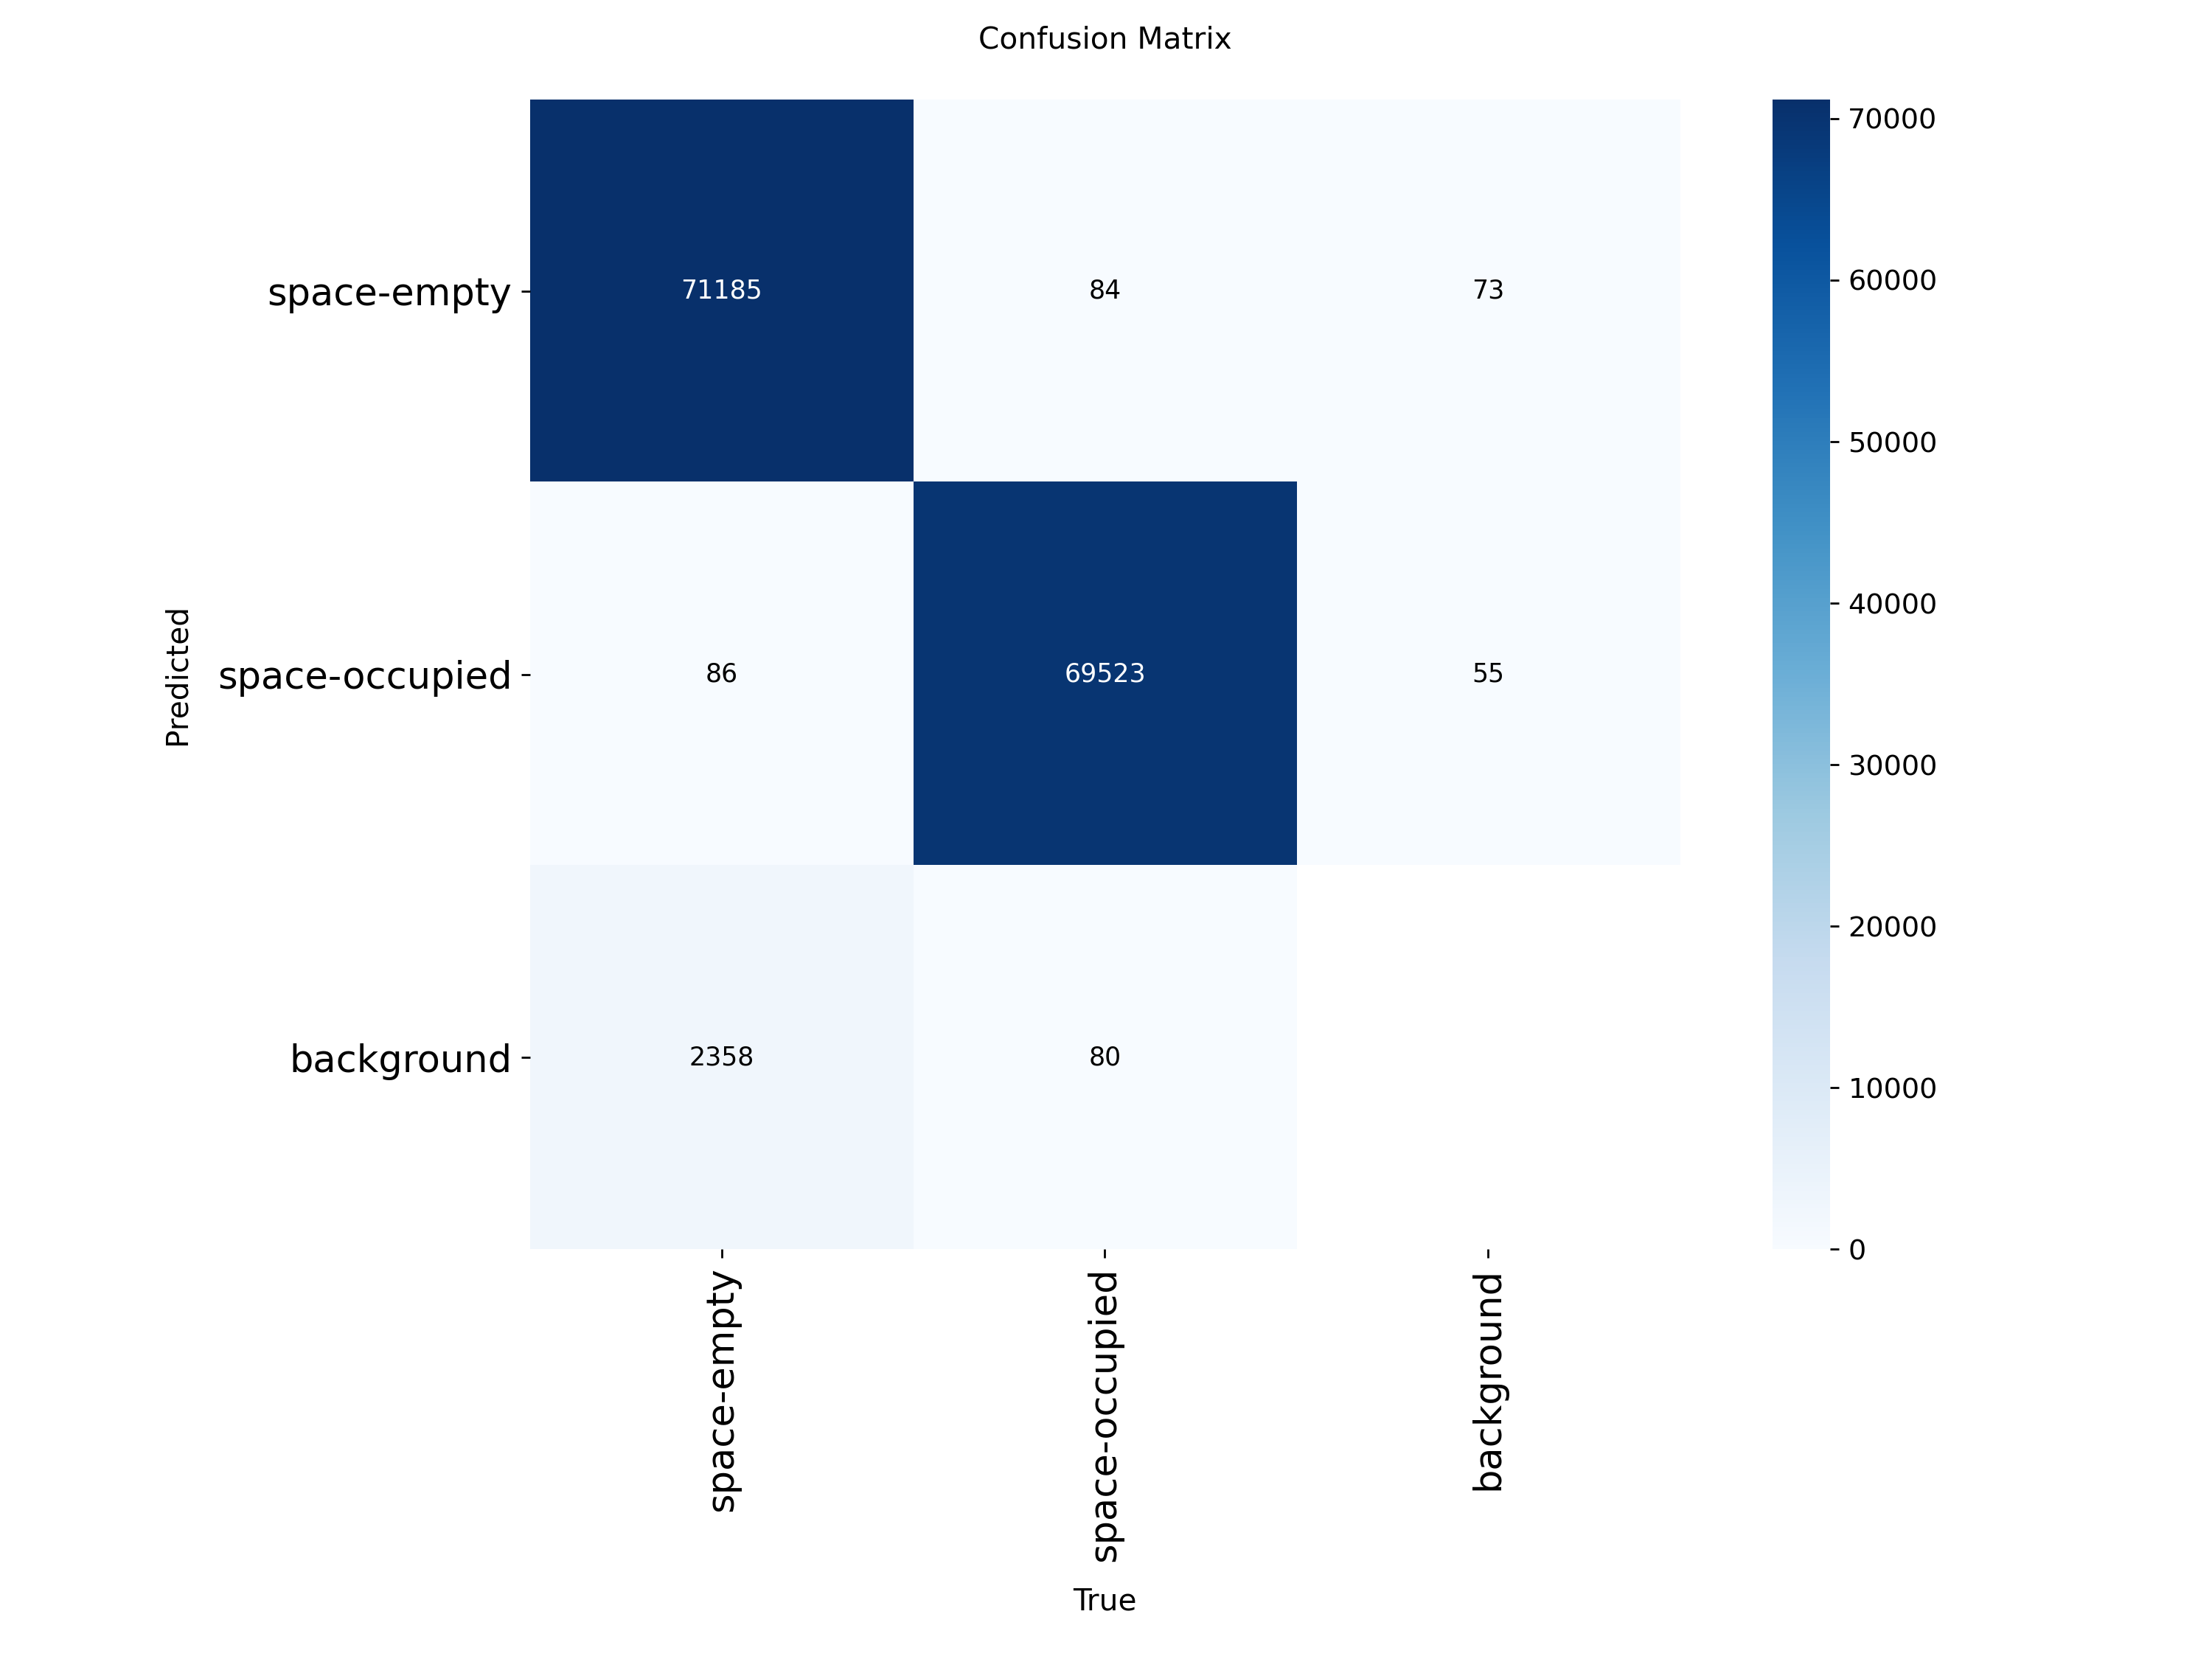

In [23]:
display(Image(filename='/content/runs/detect/train2/confusion_matrix.png'))

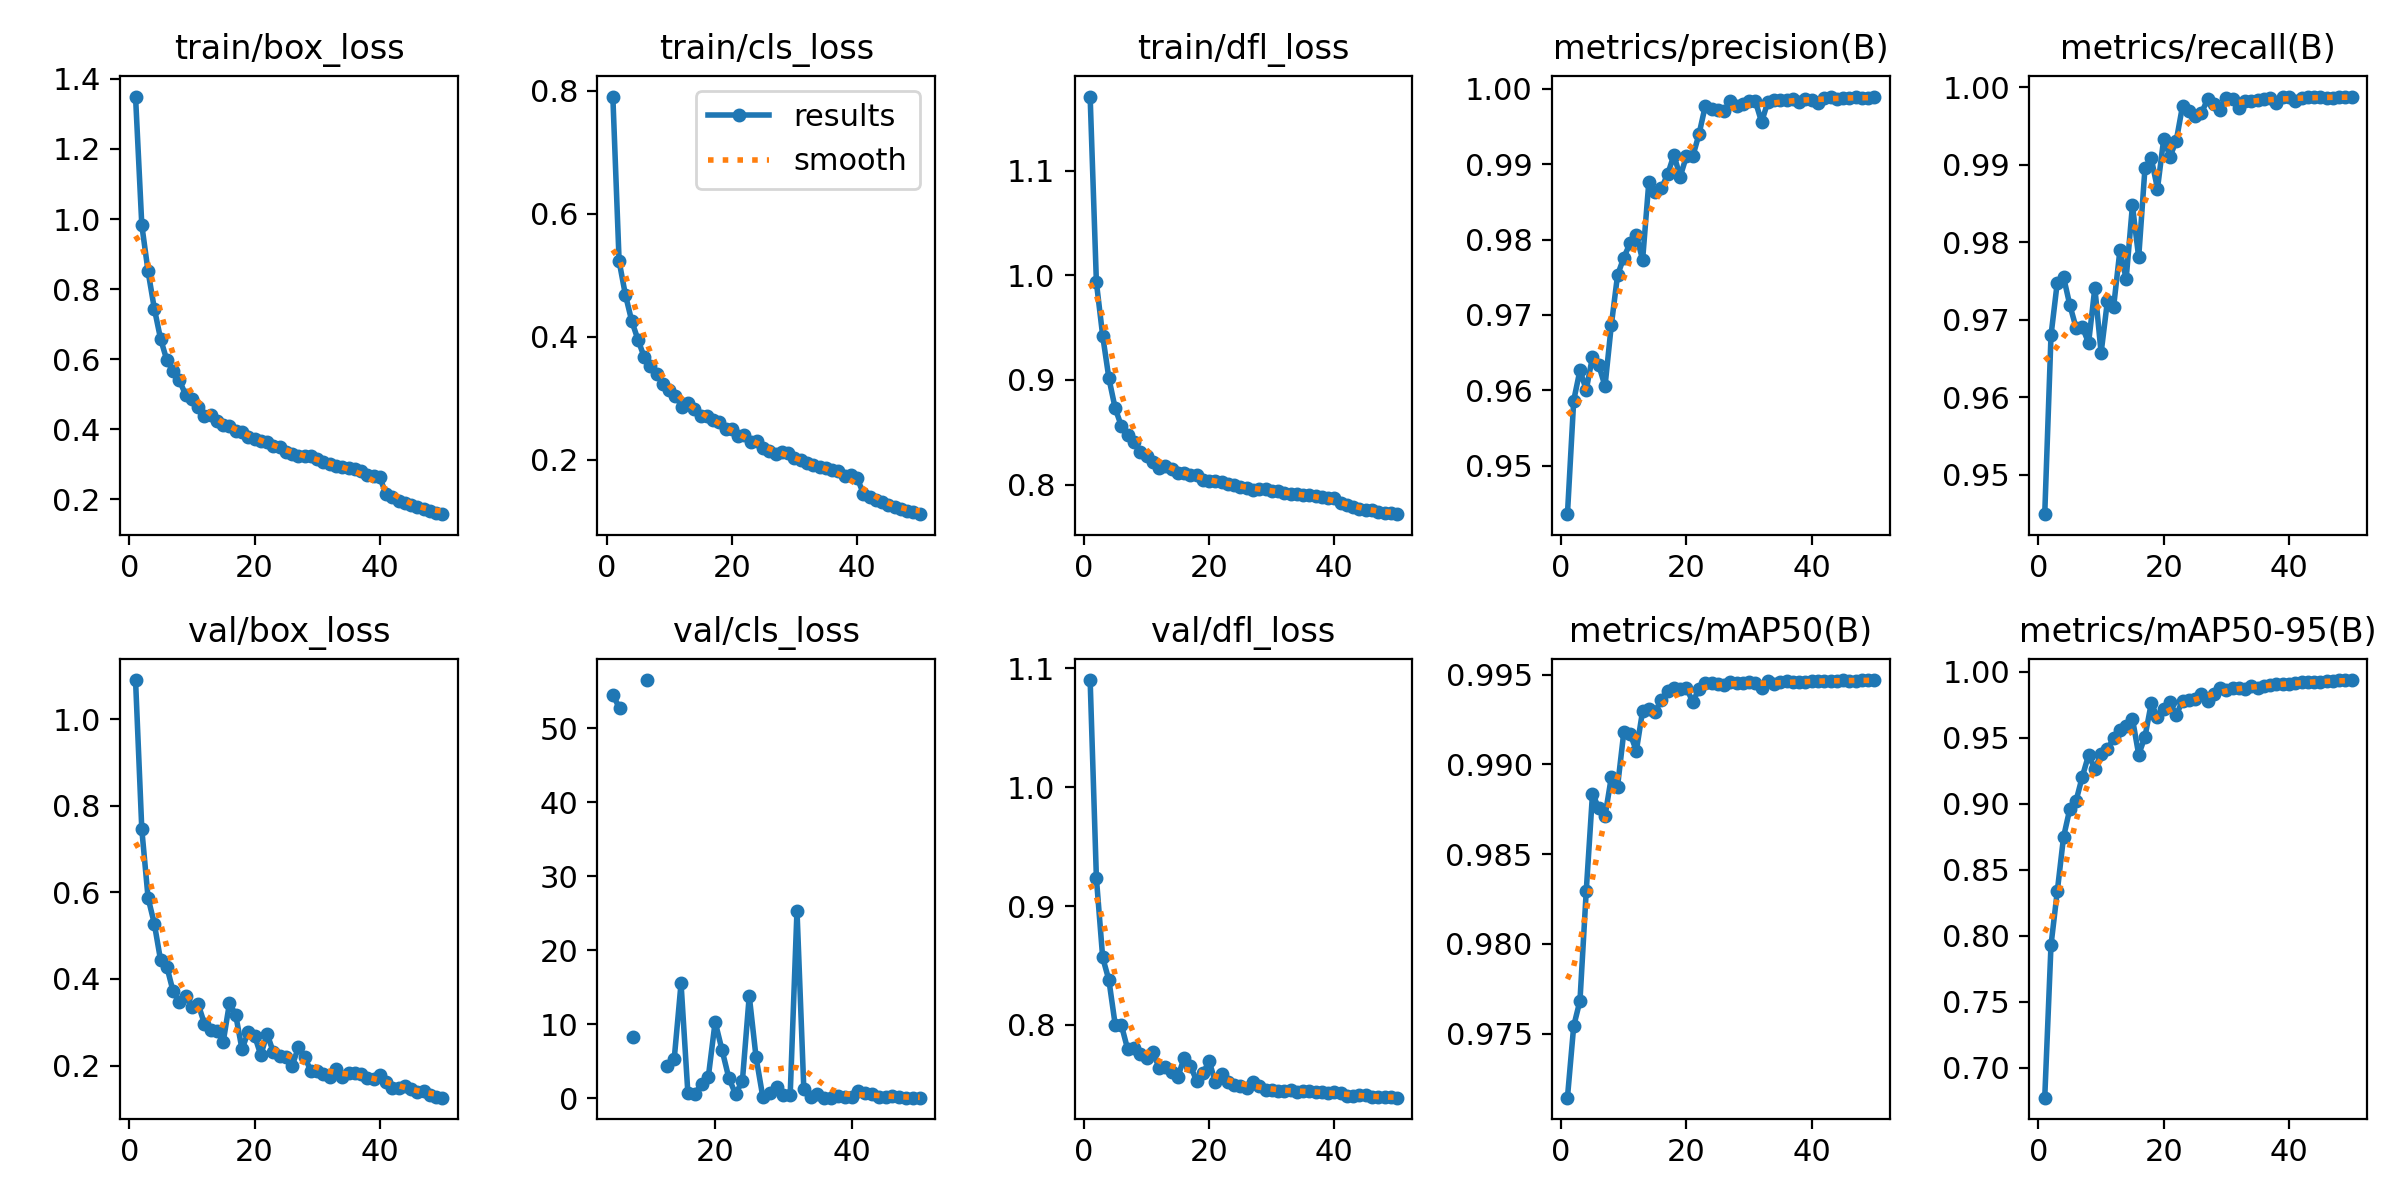

In [26]:
display(Image(filename='/content/runs/detect/train2/results.png'))

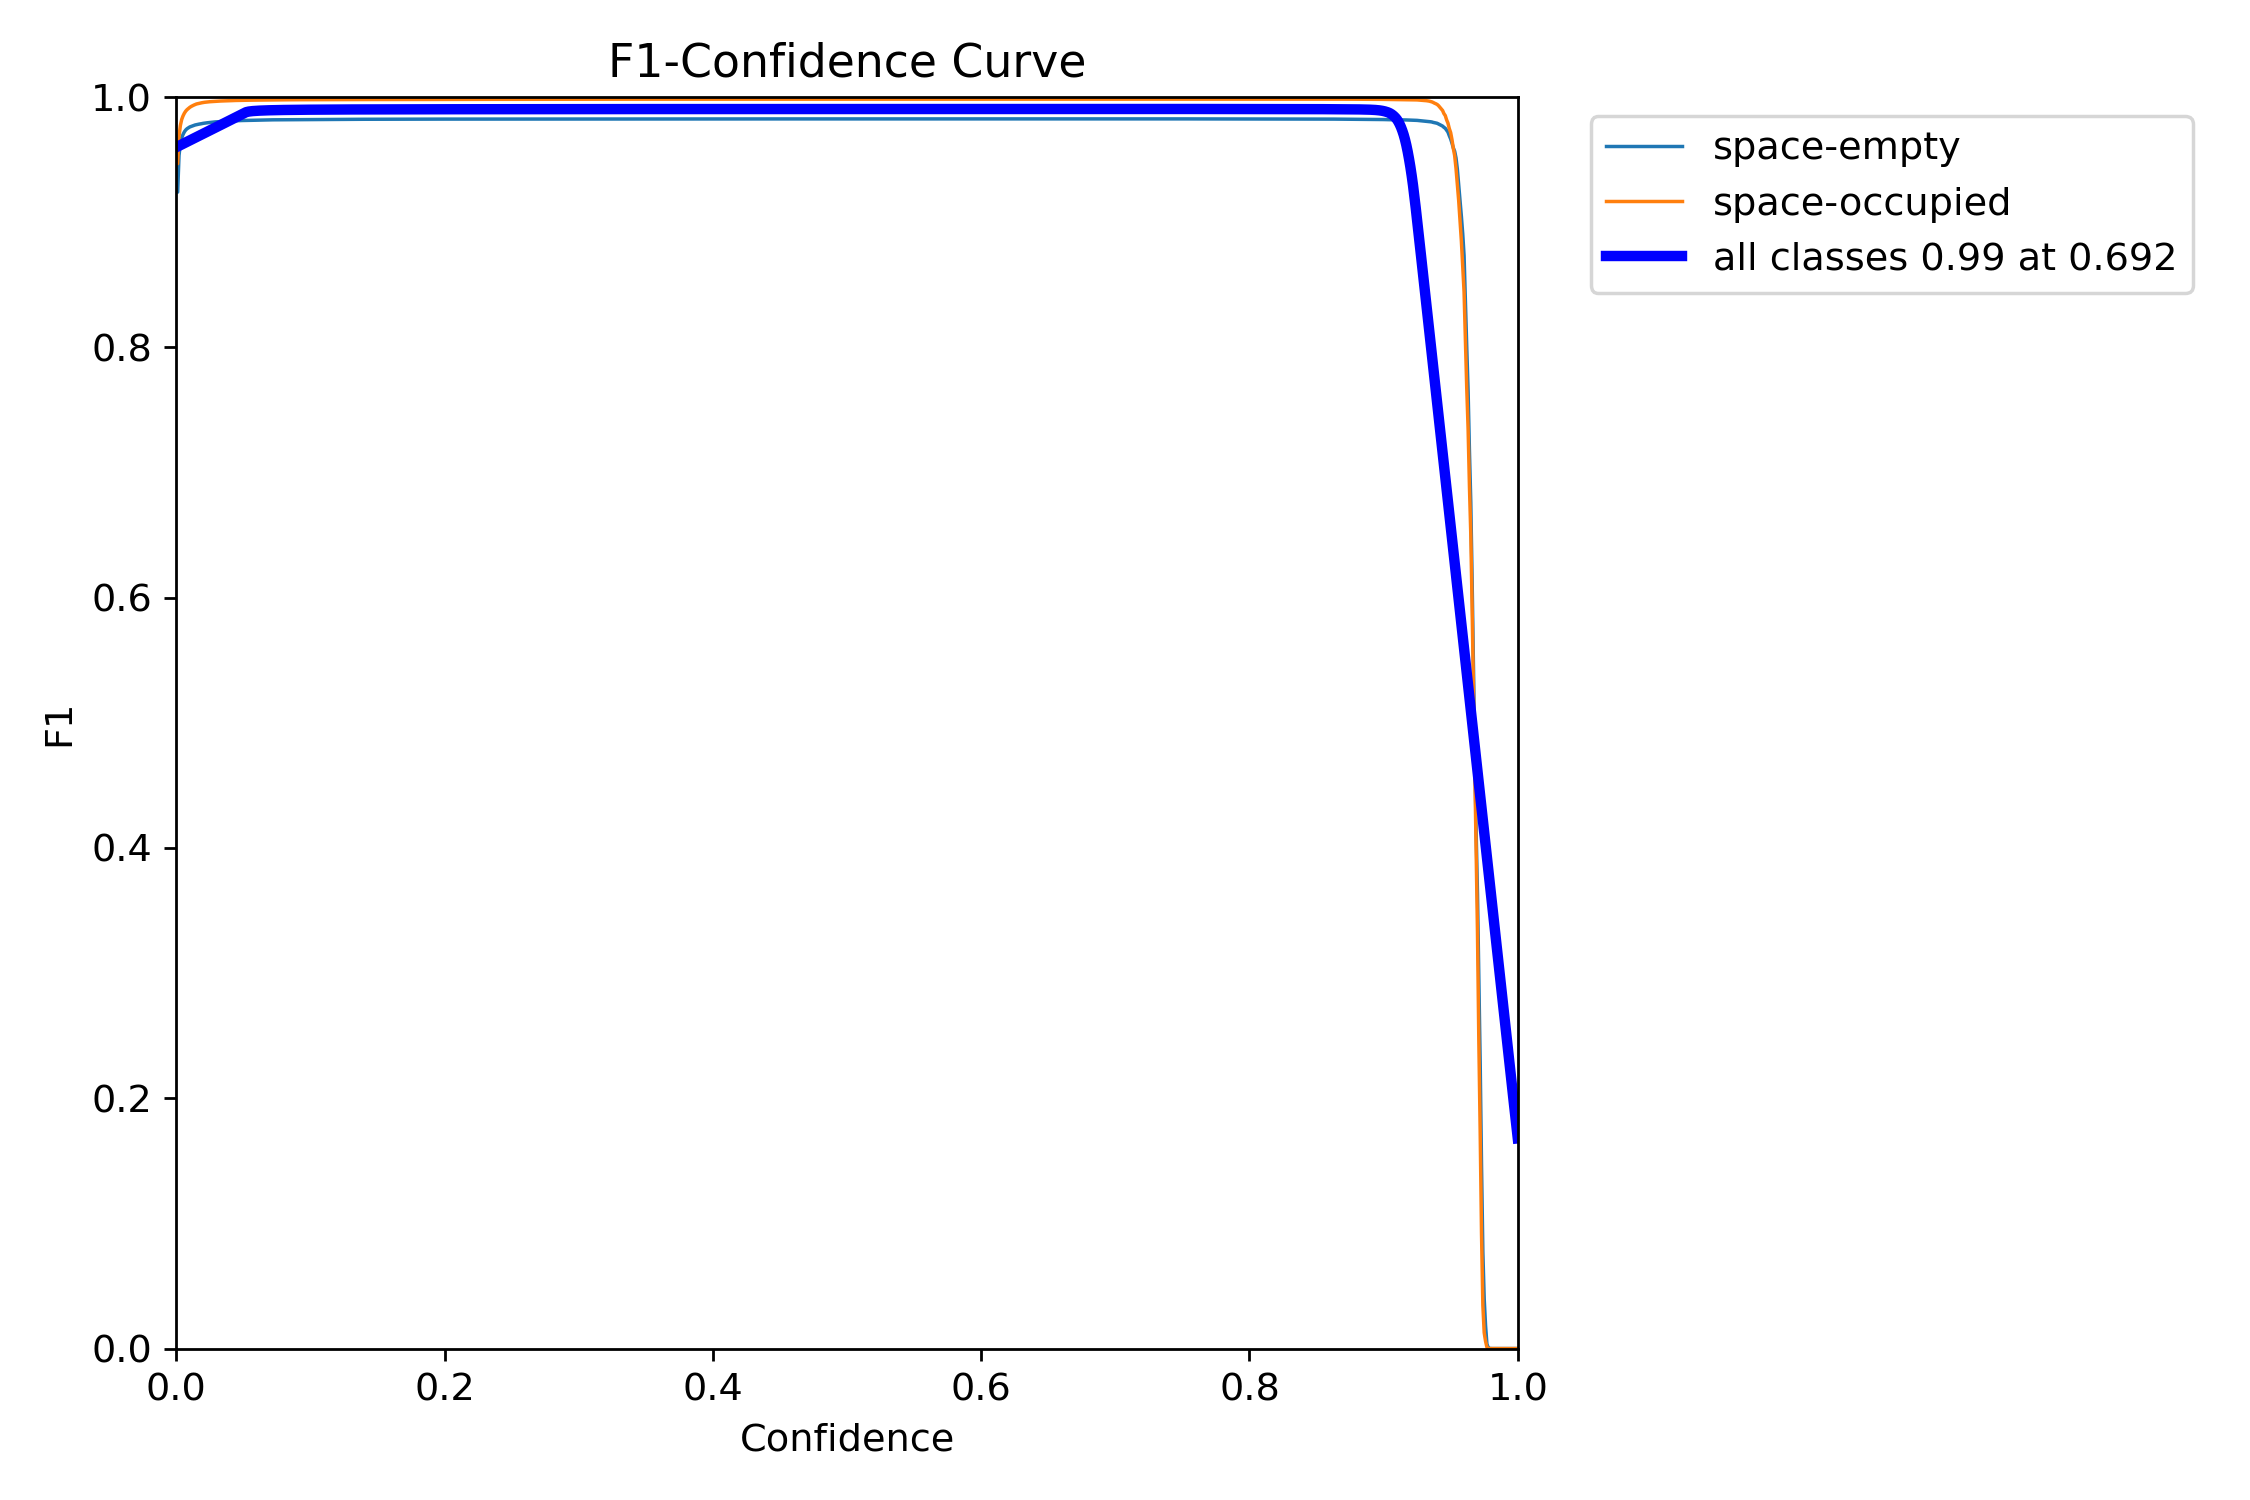

In [27]:
display(Image(filename='/content/runs/detect/train2/BoxF1_curve.png'))

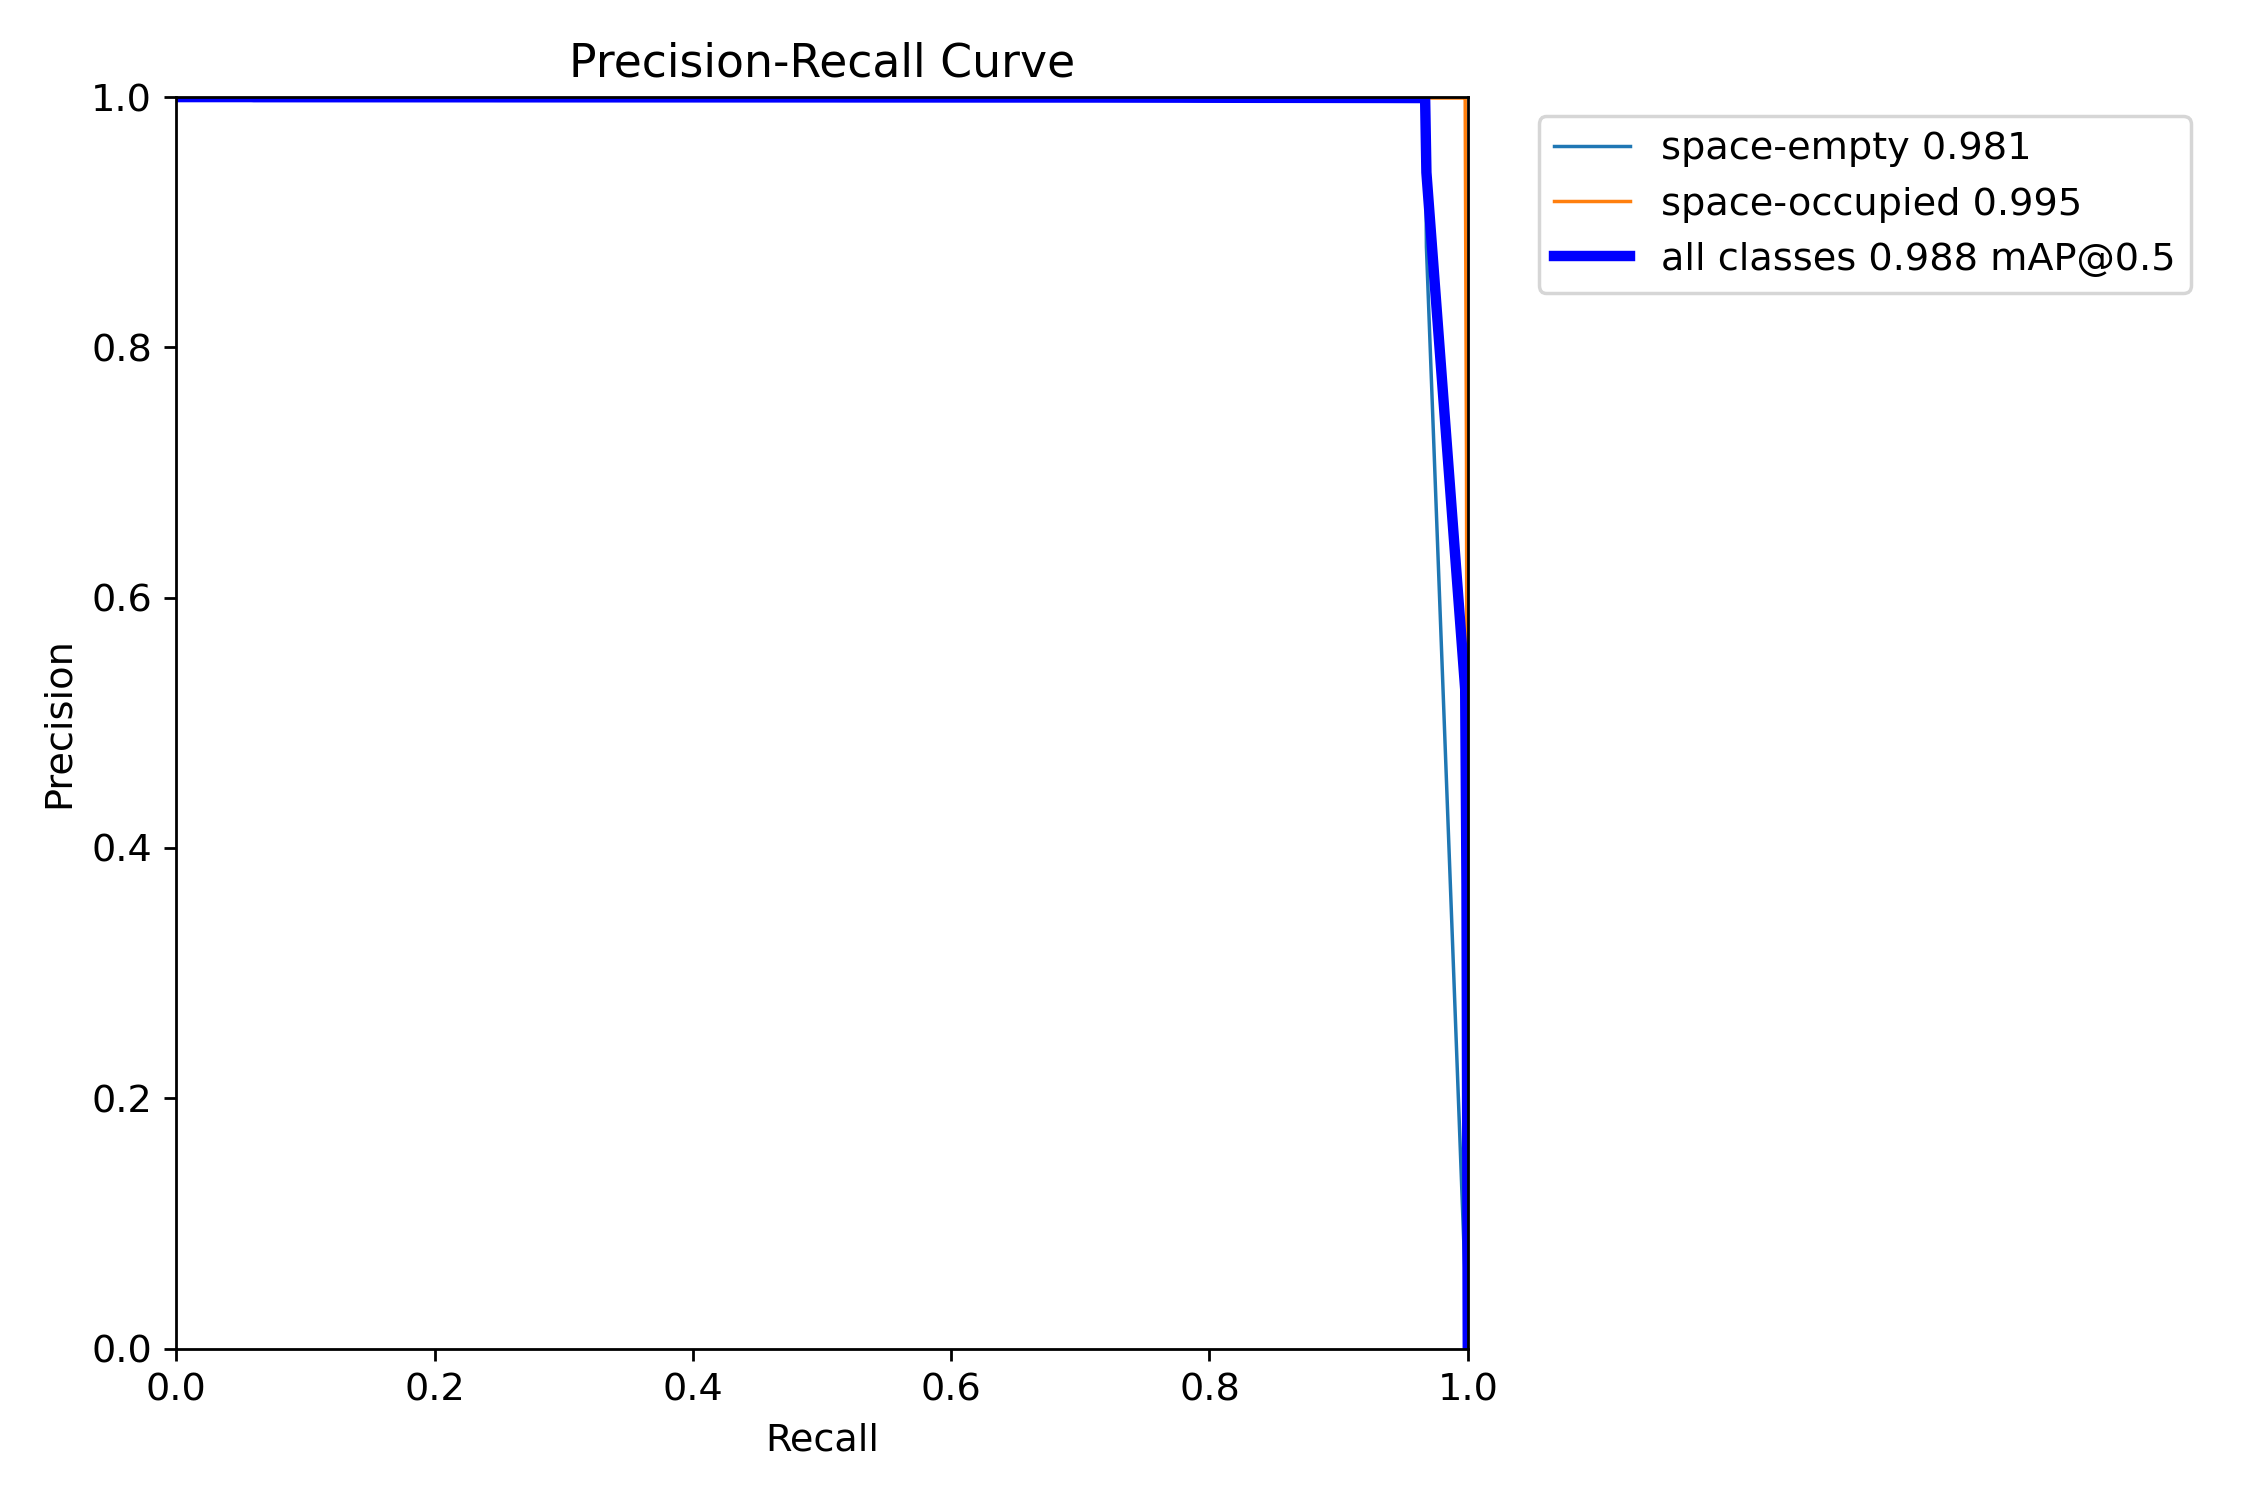

In [28]:
display(Image(filename='/content/runs/detect/train2/BoxPR_curve.png'))

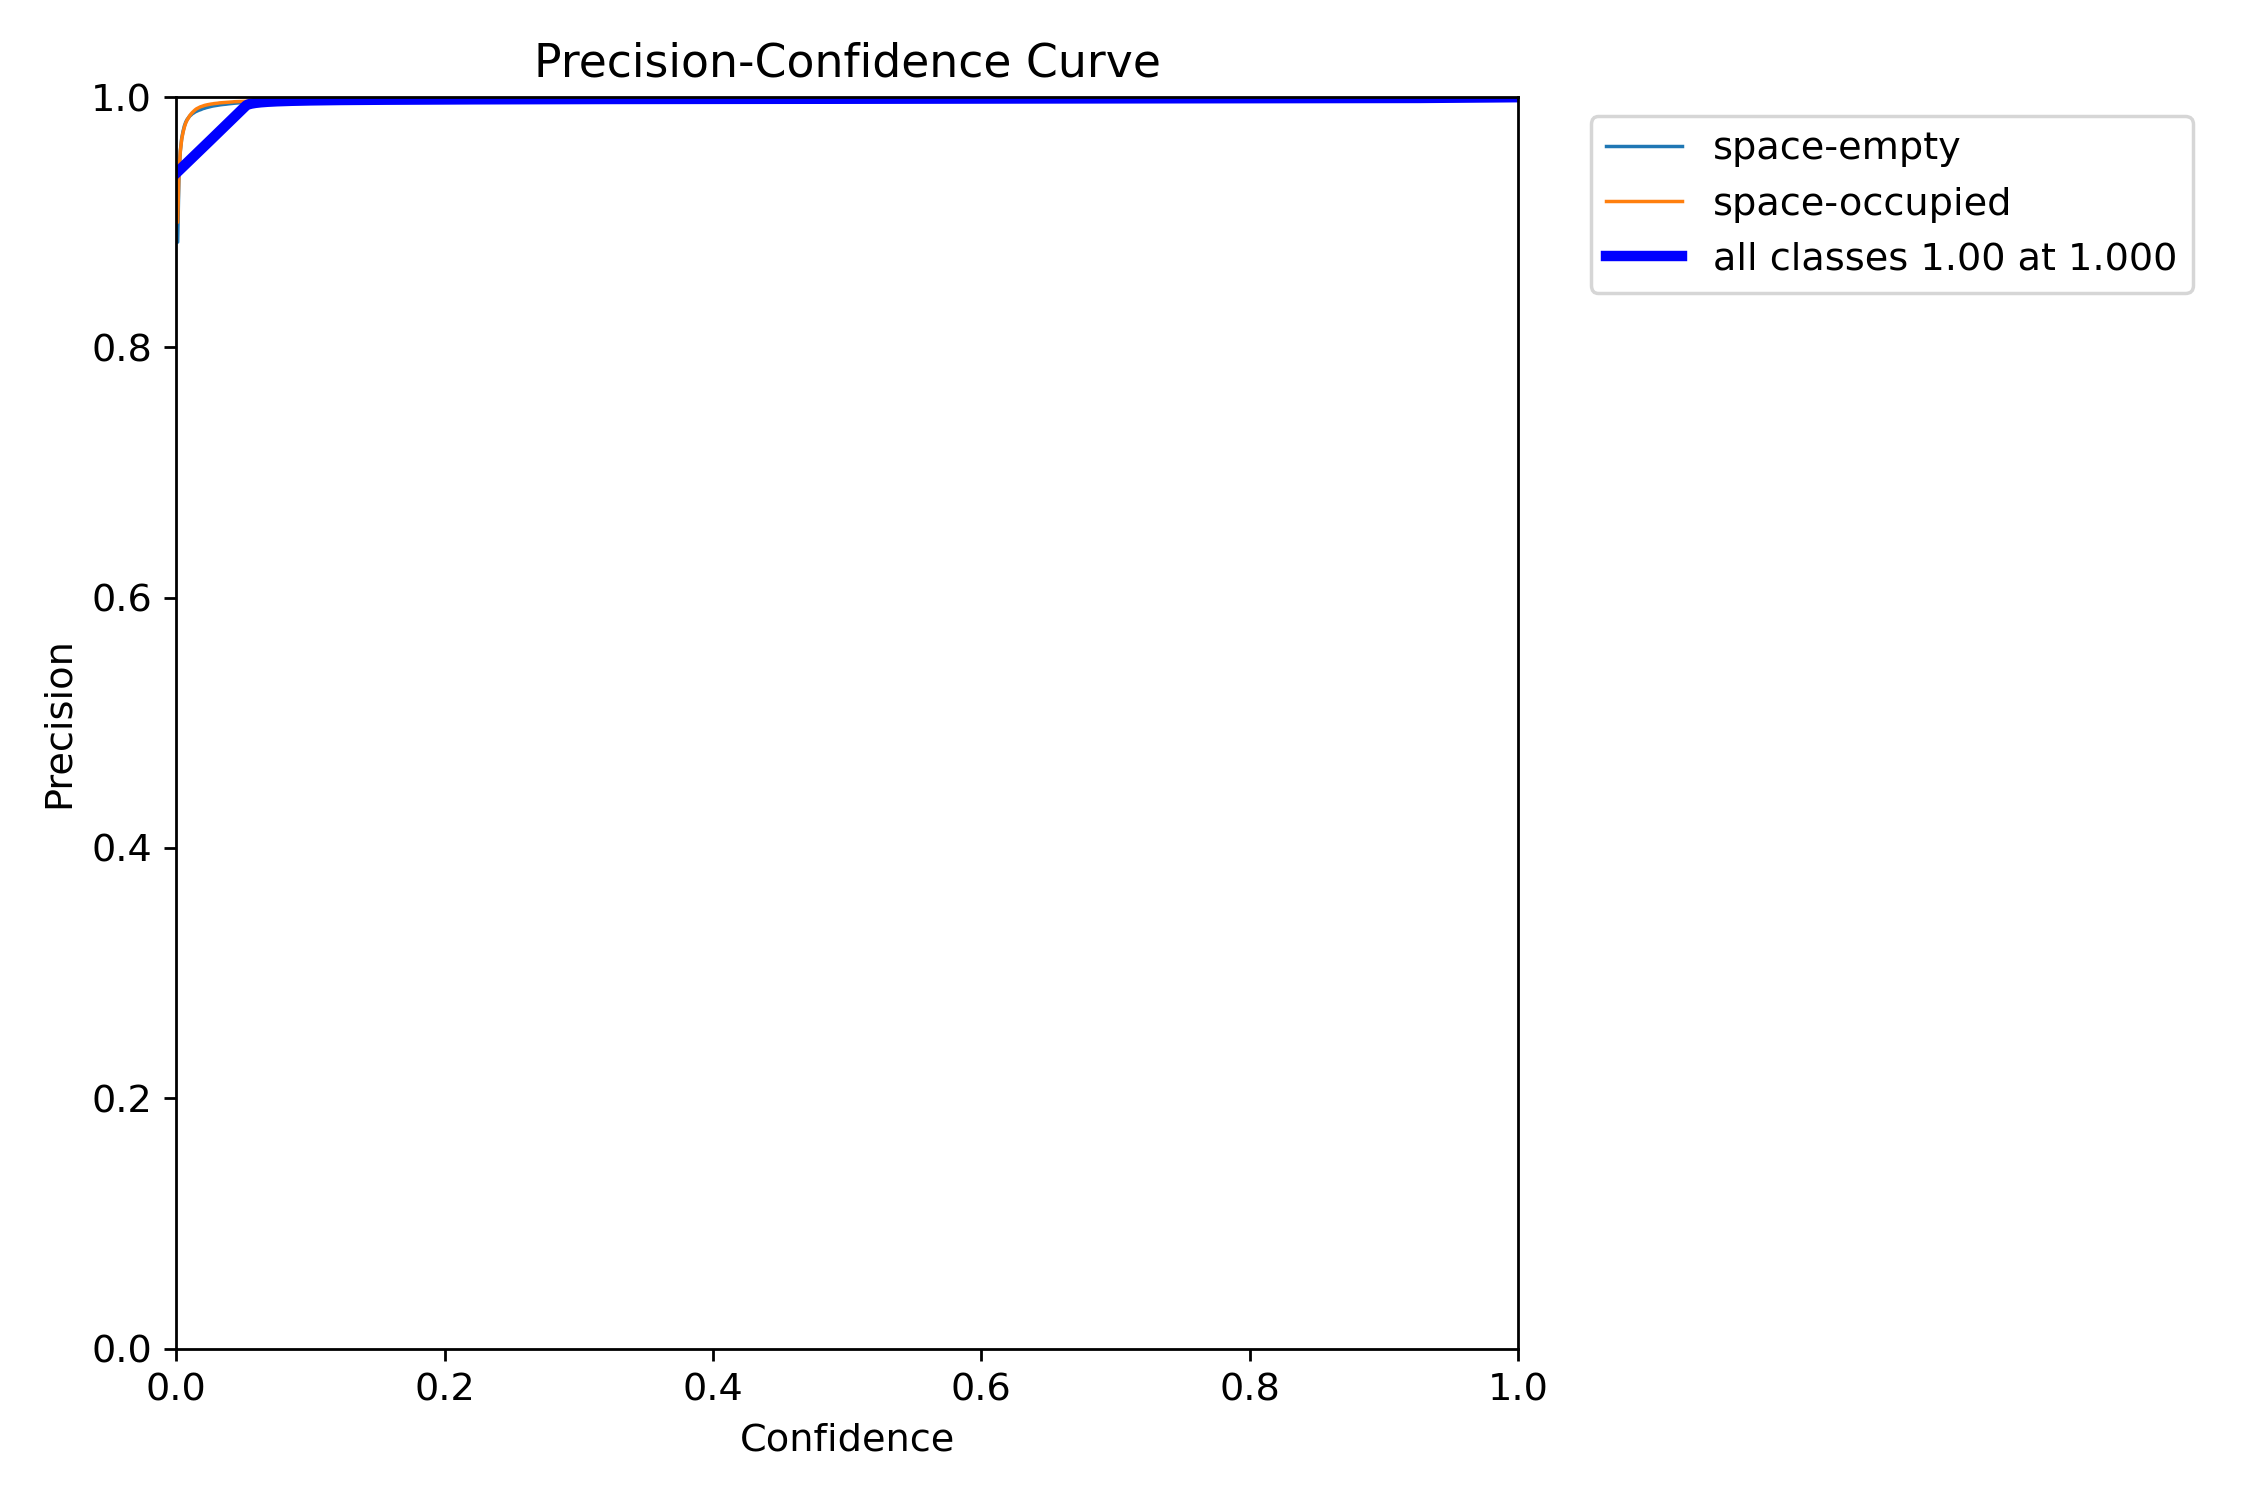

In [29]:
display(Image(filename='/content/runs/detect/train2/BoxP_curve.png'))

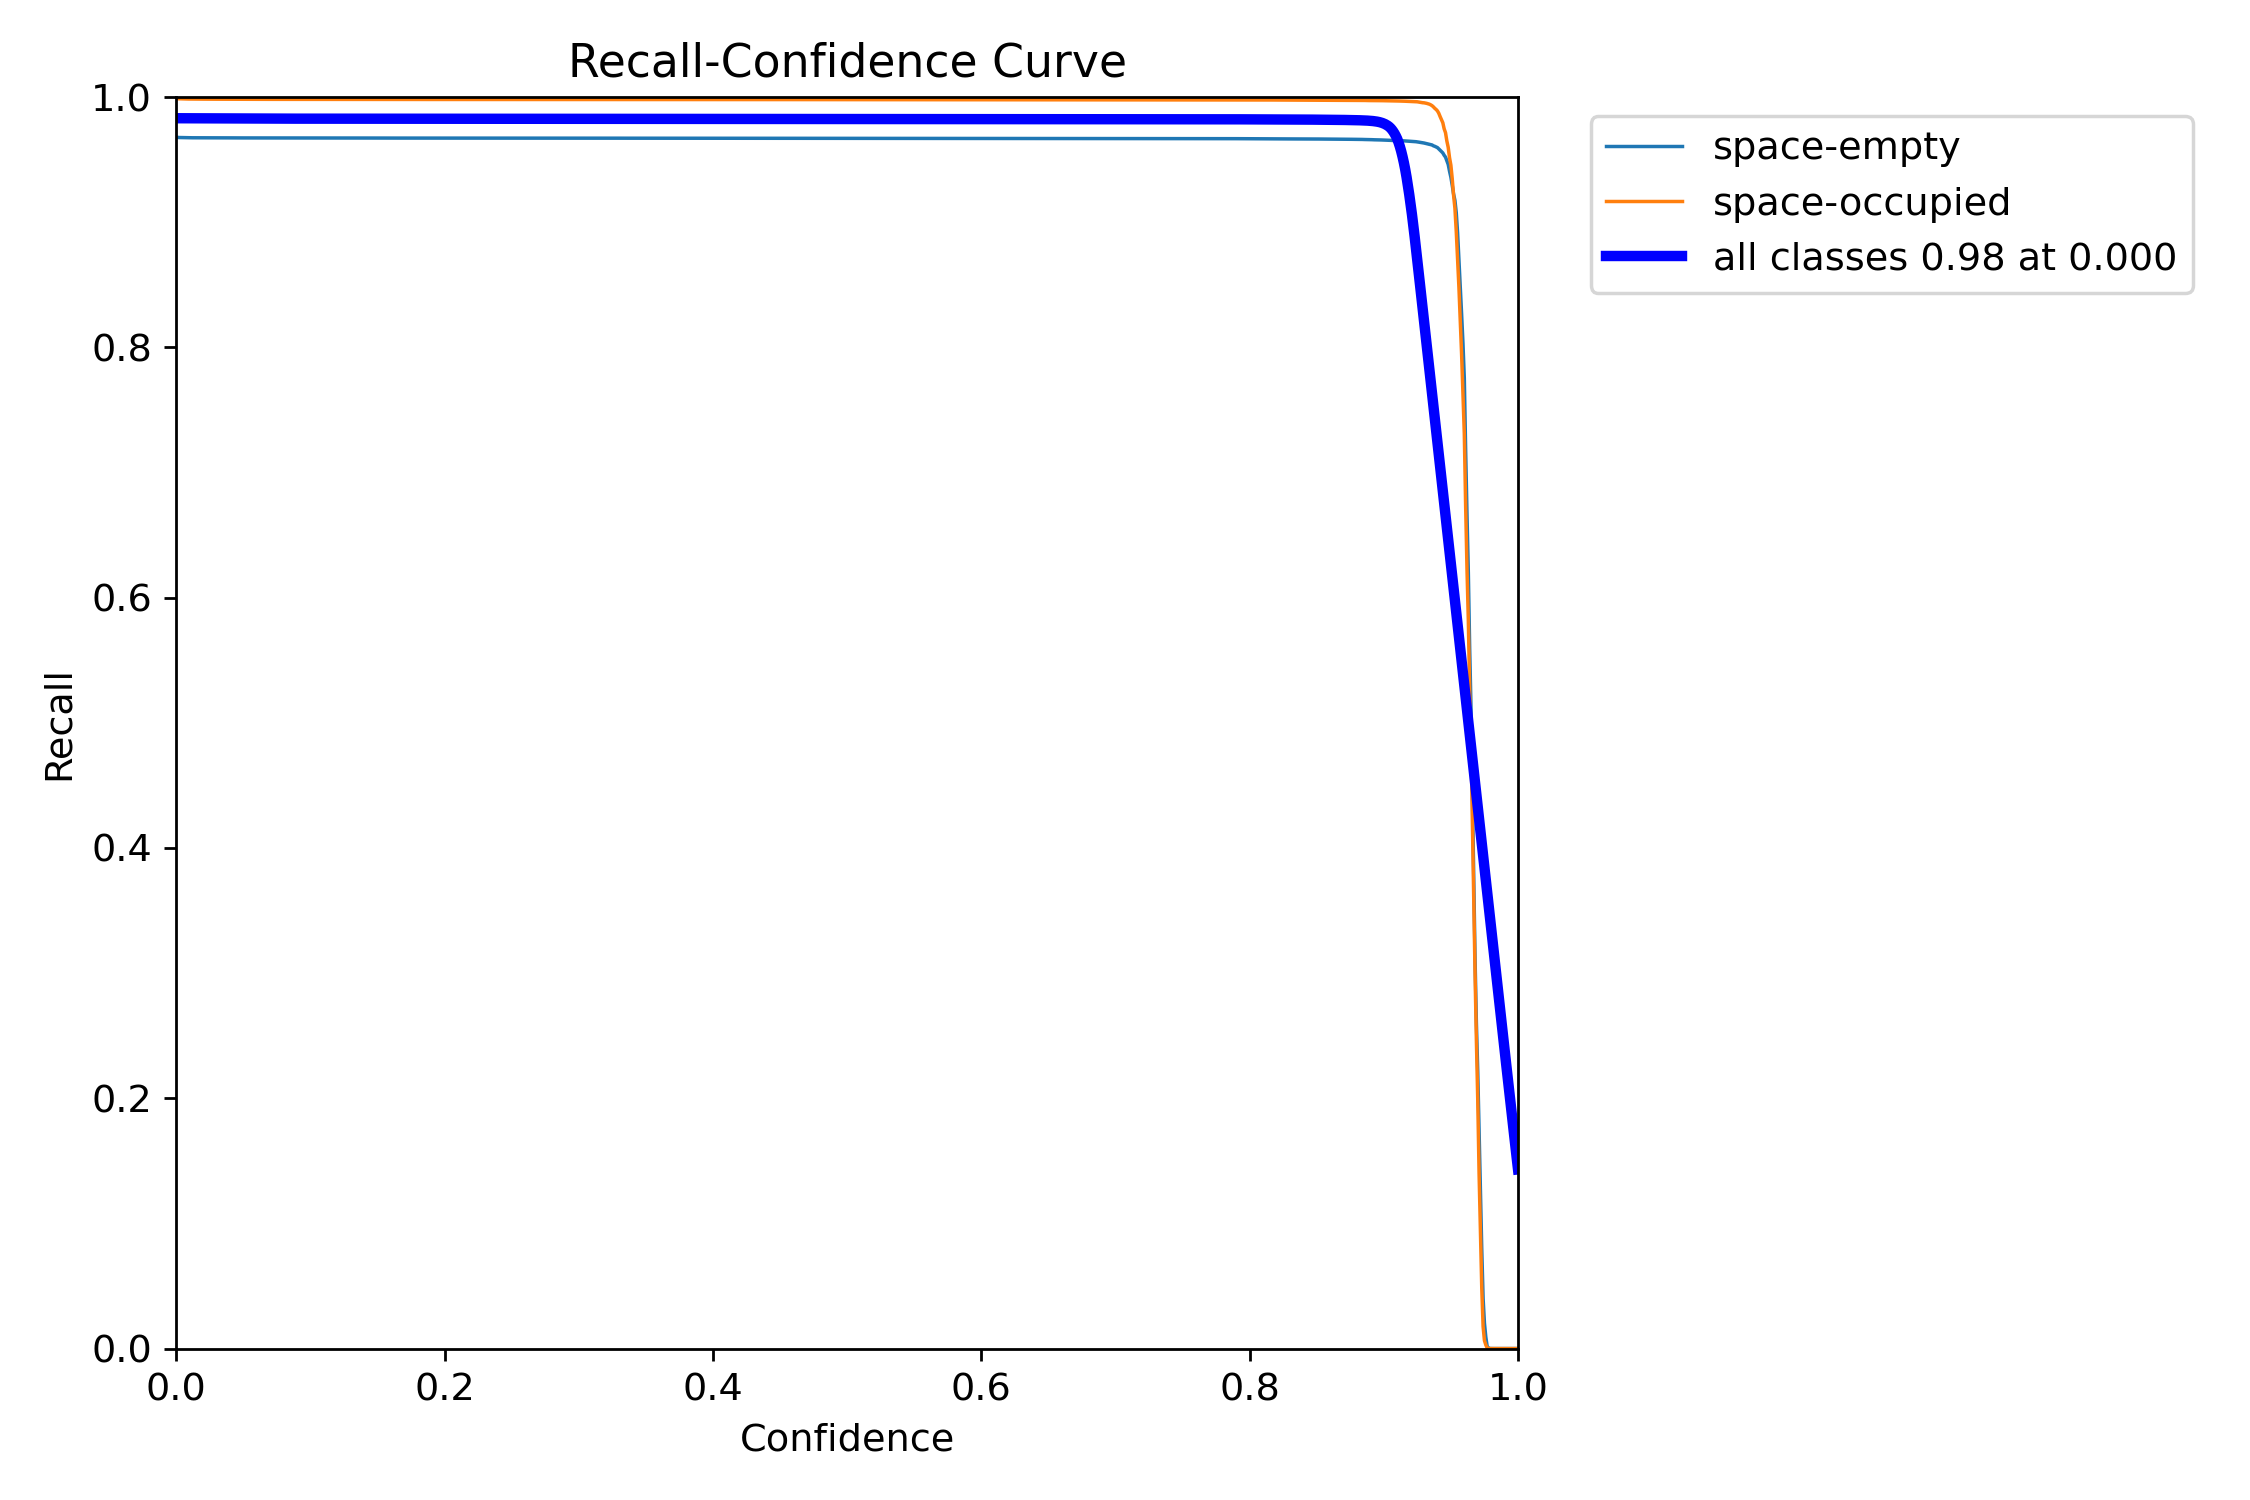

In [30]:
display(Image(filename='/content/runs/detect/train2/BoxR_curve.png'))

## 6. Inference on Test Set

In [31]:
results = model.predict(
    source="PKLot-2/test/images",
    save=True,
    conf=0.5,
    show_labels=False,
    line_thickness=1
)

WARNING ⚠️ 'line_thickness' is deprecated and will be removed in in the future. Use 'line_width' instead.

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1242 /content/PKLot-2/test/images/2012-09-11_15_53_00_jpg.rf.8282544a640a23df05bd245a9210e663.jpg: 640x640 29 space-emptys, 71 space-occupieds, 13.3ms
image 2/1242 /content/PKLot-2/test/images/2012-09-11_16_48_36_jpg.rf.4ecc8c87c61680ccc73edc218a2c8d7d.jpg: 640x640 25 space-emptys, 75 space-occupieds, 11.6ms
image 3/1242 /content/PKLot-2/te

### 6.1 Ground Truth vs YOLOv8 Predictions

In [65]:
test_image_dir = Path("/content/PKLot-2/test/images")
test_label_dir = Path("/content/PKLot-2/test/labels")
pred_image_dir = Path("/content/runs/detect/train23")

image_files = list(test_image_dir.glob("*.jpg"))

In [66]:
sampled_images = random.sample(image_files, 5)

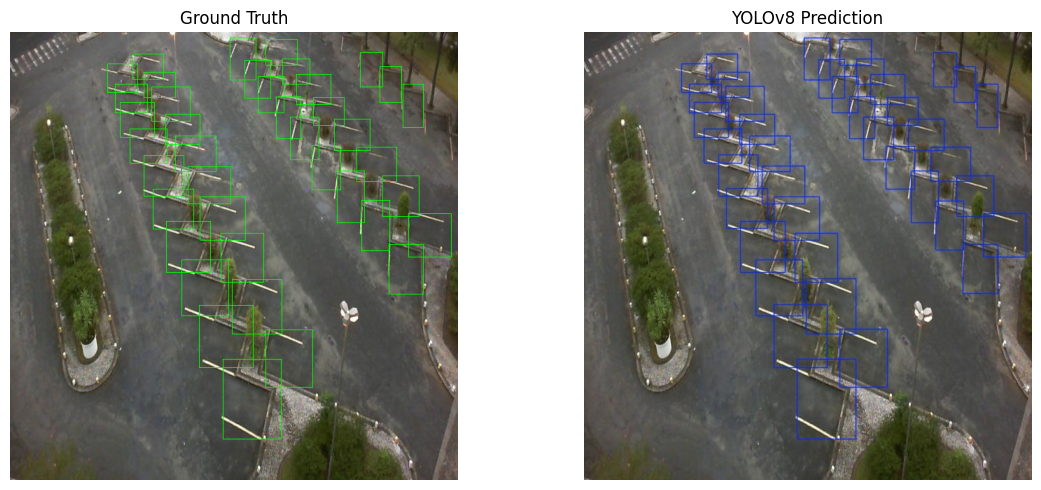

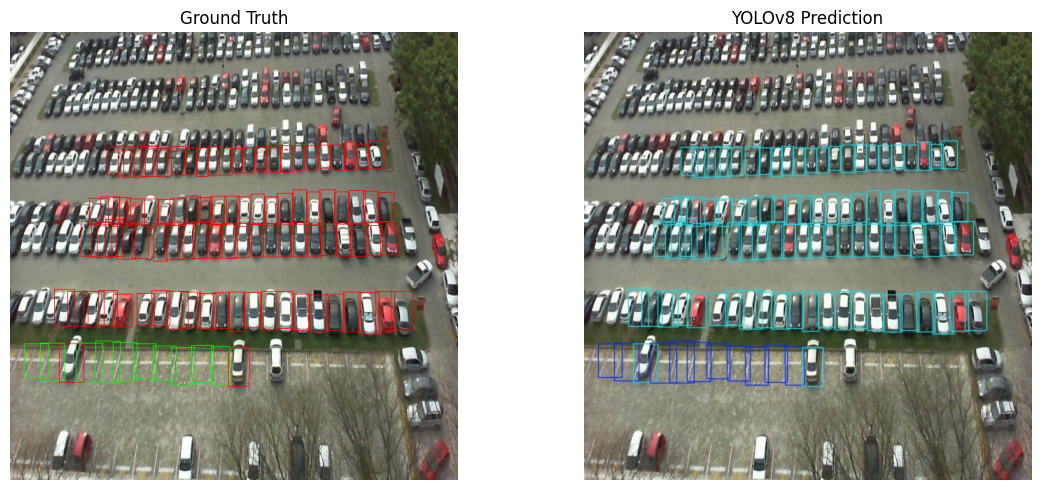

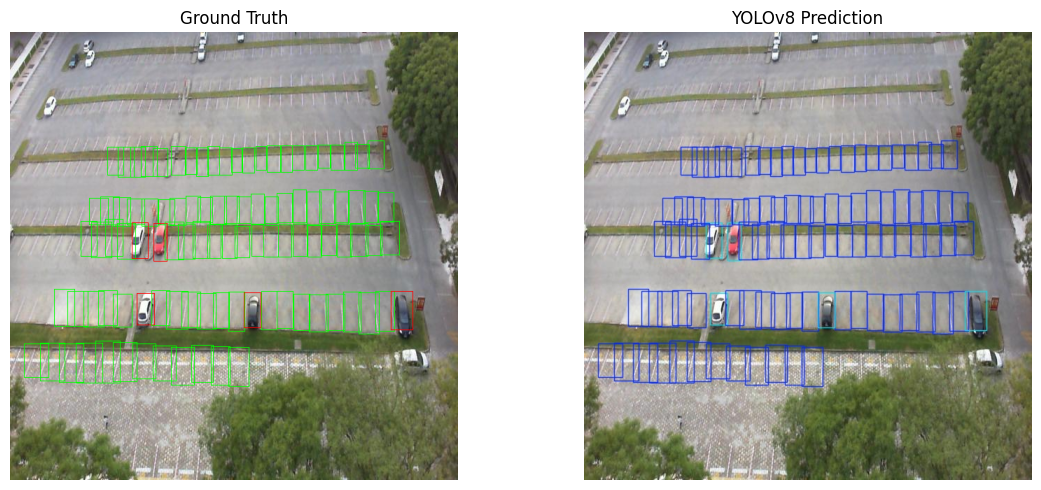

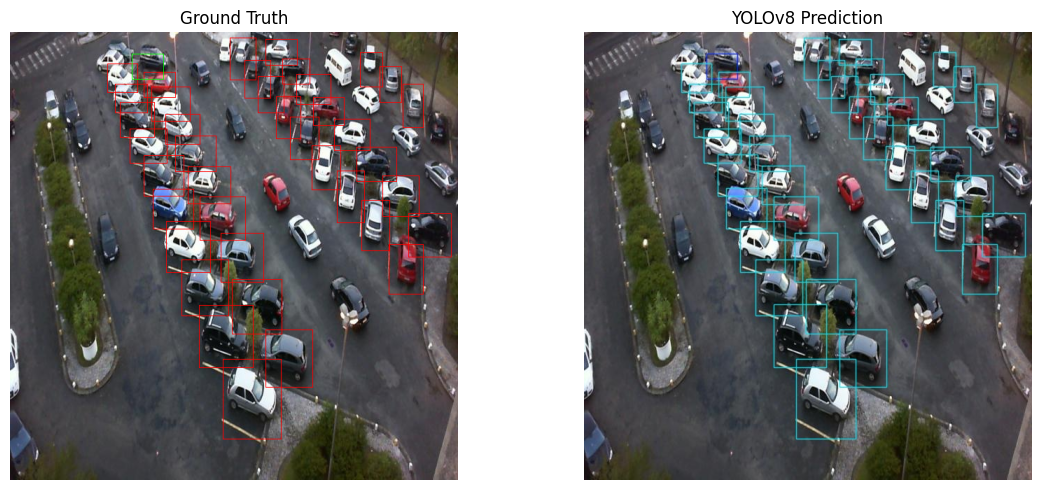

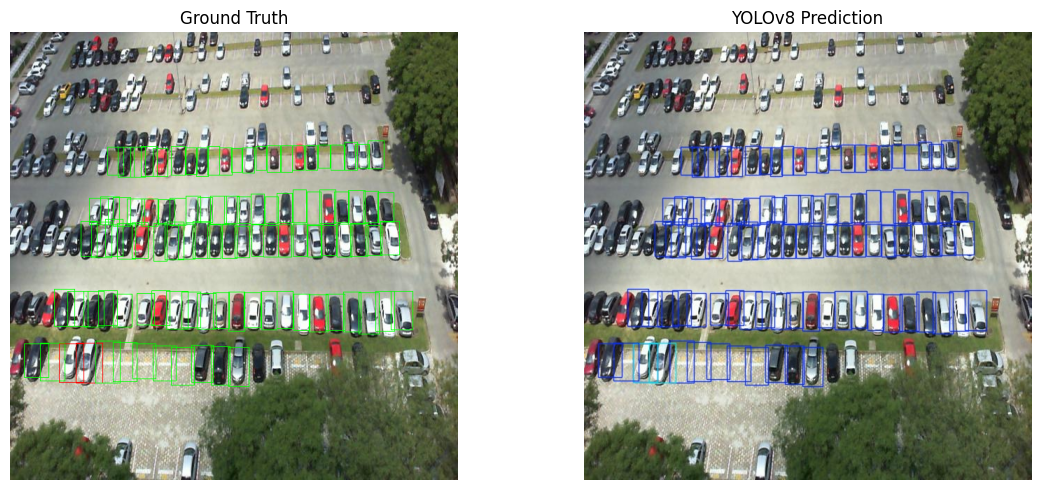

In [67]:
for img_path in sampled_images:
    img_name = img_path.name
    stem_name = img_path.stem
    label_path = test_label_dir / f"{stem_name}.txt"

    # Load original test image
    image = cv2.imread(str(img_path))
    if image is None:
        print(f"Skipping {img_path}, image not found or unreadable.")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_height, image_width, _ = image.shape

    # Draw ground truth bounding boxes
    if label_path.exists():
        with open(label_path, "r") as f:
            labels = f.readlines()

        for label in labels:
            class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.strip().split())
            x1 = int((x_center - bbox_width / 2) * image_width)
            y1 = int((y_center - bbox_height / 2) * image_height)
            x2 = int((x_center + bbox_width / 2) * image_width)
            y2 = int((y_center + bbox_height / 2) * image_height)

            color = (0, 255, 0) if int(class_id) == 0 else (255, 0, 0)
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 1)

    # Load YOLOv8 predicted image
    pred_img_path = pred_image_dir / img_name
    pred_img = cv2.imread(str(pred_img_path))
    if pred_img is None:
        print(f"Prediction not found for {img_name}")
        continue

    pred_img = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_img)
    plt.title("YOLOv8 Prediction")
    plt.axis("off")

    plt.tight_layout()
    plt.show()